<a href="https://colab.research.google.com/github/rohinidat/2-CHL5230-F23/blob/main/Abdualziz_Sherif_Datathon_5_Objective_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch as t
import torch.nn as nn
import numpy as np
import seaborn as sns
from torch.nn.functional import sigmoid, relu, tanh
from torch.optim import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import Tanh, Linear, Sequential, Sigmoid, Dropout
from sklearn.model_selection import train_test_split

In [5]:
data = pd.read_csv('/content/mhealth.csv')
data.head()

,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
0,2.1849,-9.6967,0.63077,0.103900,-0.84053,-0.68762,-8.6499,-4.5781,0.187760,-0.44902,-1.0103,0.034483,0,subject1
1,2.3876,-9.5080,0.68389,0.085343,-0.83865,-0.68369,-8.6275,-4.3198,0.023595,-0.44902,-1.0103,0.034483,0,subject1
2,2.4086,-9.5674,0.68113,0.085343,-0.83865,-0.68369,-8.5055,-4.2772,0.275720,-0.44902,-1.0103,0.034483,0,subject1
3,2.1814,-9.4301,0.55031,0.085343,-0.83865,-0.68369,-8.6279,-4.3163,0.367520,-0.45686,-1.0082,0.025862,0,subject1
4,2.4173,-9.3889,0.71098,0.085343,-0.83865,-0.68369,-8.7008,-4.1459,0.407290,-0.45686,-1.0082,0.025862,0,subject1


#Data Exploration

In [ ]:
data.dtypes

alx         float64
aly         float64
alz         float64
glx         float64
gly         float64
glz         float64
arx         float64
ary         float64
arz         float64
grx         float64
gry         float64
grz         float64
Activity      int64
subject      object
dtype: object

In [ ]:
missing_values = data.isnull().sum()
print(missing_values)

alx         0
aly         0
alz         0
glx         0
gly         0
glz         0
arx         0
ary         0
arz         0
grx         0
gry         0
grz         0
Activity    0
subject     0
dtype: int64


In [6]:
print(data.describe())

                 alx            aly            alz            glx  \
count  999999.000000  999999.000000  999999.000000  999999.000000   
mean        1.473954      -9.618162      -0.944714      -0.023928   
std         3.751845       4.076683       5.333969       0.495758   
min       -22.146000     -19.619000     -19.373000      -2.146600   
25%         0.115100     -10.116000      -2.662400      -0.454550   
50%         1.336800      -9.644800      -0.016372      -0.070501   
75%         2.586900      -9.034300       1.371500       0.426720   
max        20.054000      21.161000      25.015000      60.484000   

                 gly            glz            arx           ary  \
count  999999.000000  999999.000000  999999.000000  999999.00000   
mean       -0.616830      -0.131466      -3.578801      -5.72591   
std         0.354135       0.547774       4.770602       5.70559   
min        -7.789900      -2.567800     -22.361000     -18.97200   
25%        -0.816140      -0.561890   

Text(0.5, 1.0, 'Count of Activity')

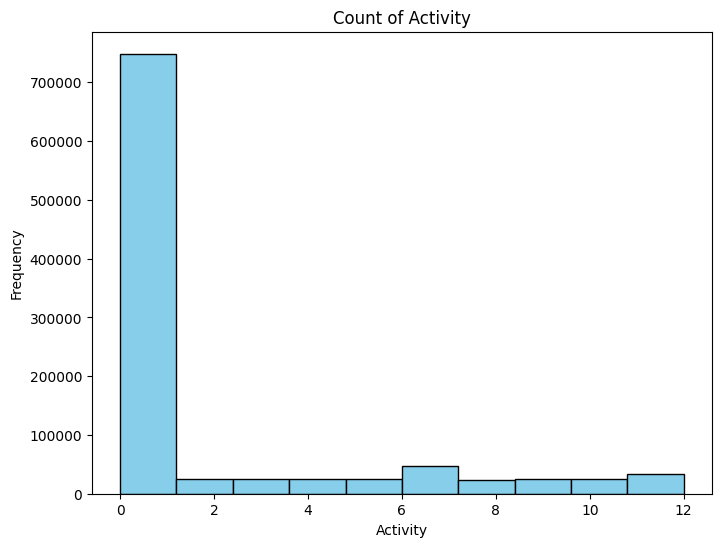

In [ ]:
# Create histogram for activity
plt.figure(figsize=(8, 6))  # Optional: Adjust figure size
plt.hist(data['Activity'], bins=10, color='skyblue', edgecolor='black')

# Customize labels and title
plt.xlabel('Activity')
plt.ylabel('Frequency')
plt.title('Count of Activity')

<ipython-input-10-64c073ad6437>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = data.corr()


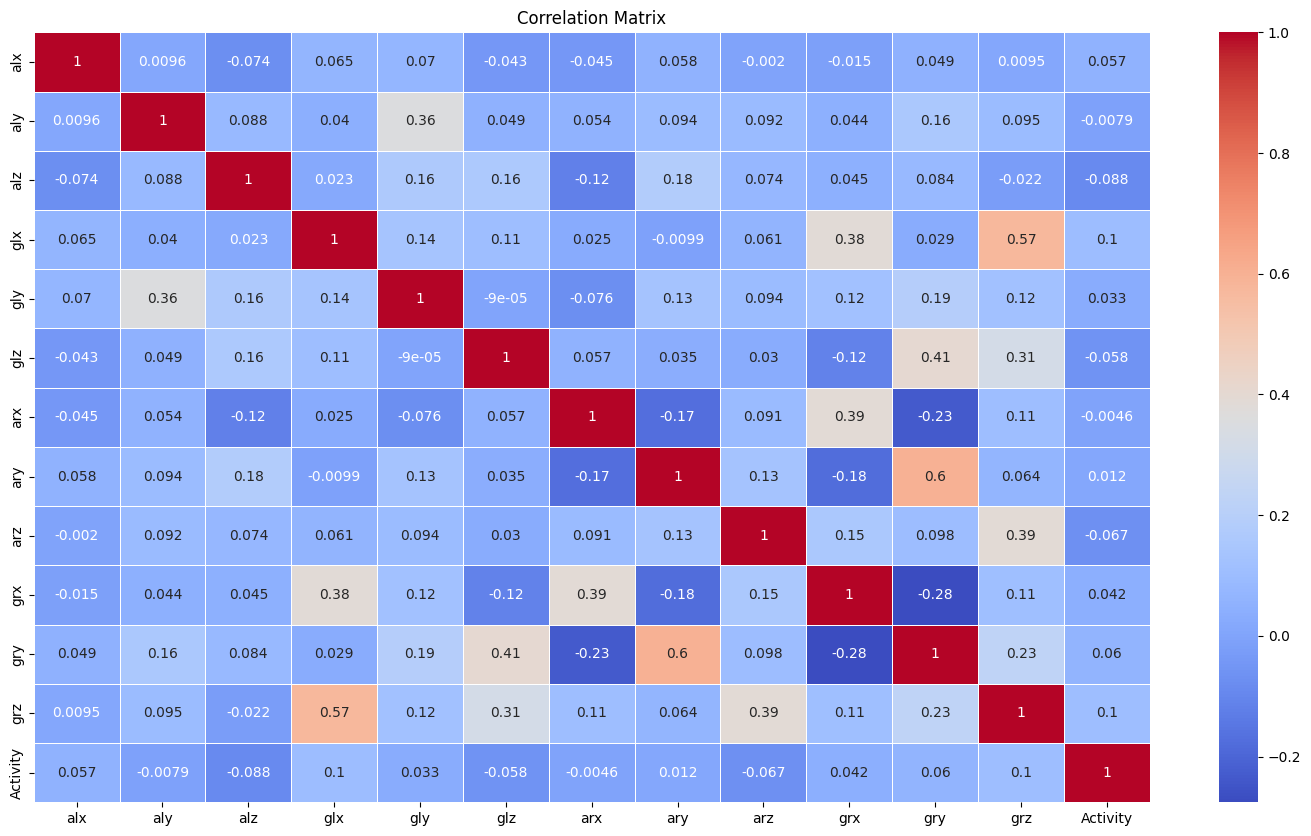

In [ ]:
correlations = data.corr()
plt.figure(figsize=(18, 10))
sns.heatmap(correlations, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

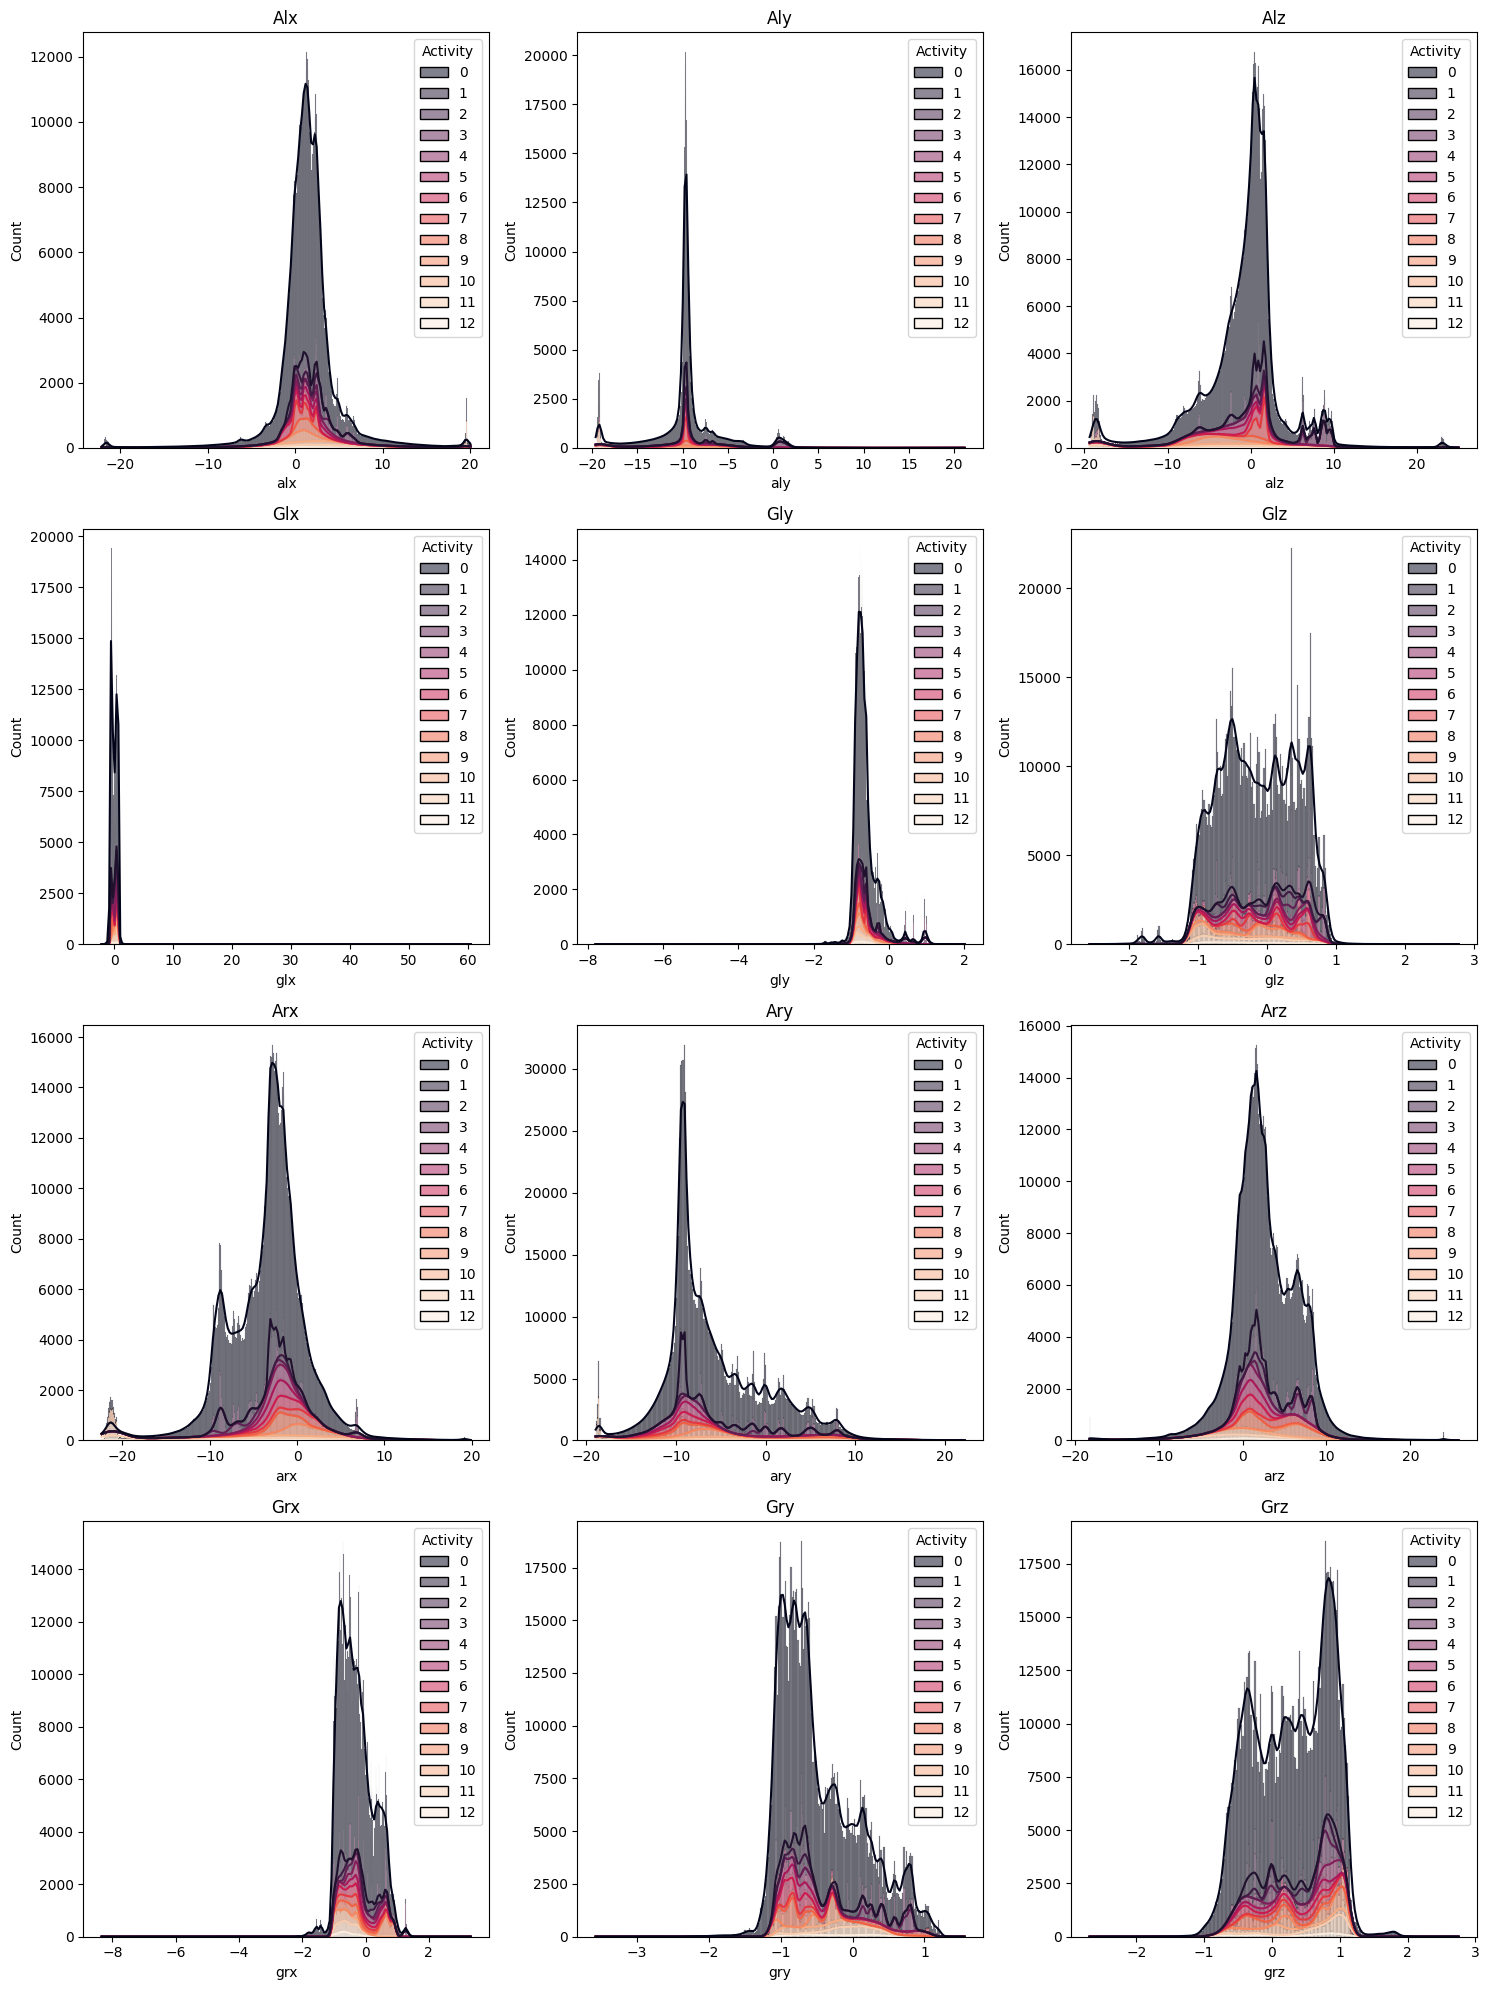

In [ ]:
# Select columns to plot features frequencies
selected_columns = data.columns.drop(['Activity', 'subject'])

# Create a grid of subplots with 4 rows and 3 columns for 12 plots
fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(15, 20))

# Loop over each selected feature to create a subplot for each
for i, column in enumerate(selected_columns):
    # Calculate the position for the subplot; x is the row index and y is the column index
    x = i // 3
    y = i % 3

    # Plot a histogram of the feature split by the 'activity' class
    sns.histplot(data, x=column, hue='Activity', kde=True, palette='rocket', ax=axs[x][y],
                 multiple='stack')
    axs[x][y].set_title(column.replace('_', ' ').title())

# Adjust the layout and display all the subplots
plt.tight_layout()
plt.show()

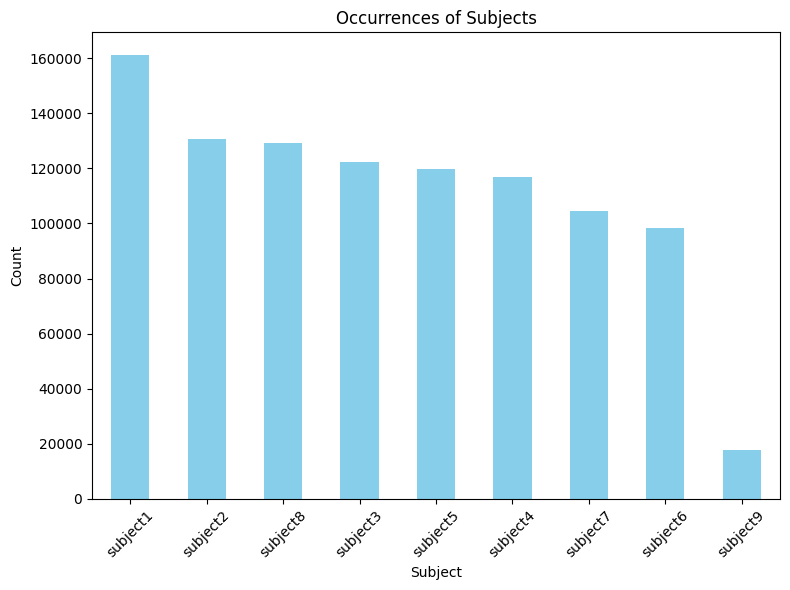

In [ ]:
subject_counts = data['subject'].value_counts()

# Create a bar plot for subject counts
plt.figure(figsize=(8, 6))
subject_counts.plot(kind='bar', color='skyblue')
plt.title('Occurrences of Subjects')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

#LSTM Model

###Data Preperation

In [7]:
# Grouping by subject and creating a list of dataframes, one per group
grouped = data.groupby('subject')
grouped_data = [group for _, group in grouped]

# Splitting the groups into training and test sets with an 80:20 ratio
train_groups, test_groups = train_test_split(grouped_data, test_size=0.2, random_state=42)

# Reassembling the training and test datasets from the groups
train_data = pd.concat(train_groups)
test_data = pd.concat(test_groups)

# Displaying the shape of the training and test sets
train_data_shape = train_data.shape
test_data_shape = test_data.shape

train_data_shape, test_data_shape

((740414, 14), (259585, 14))

In [8]:
# Identifying numerical columns
numerical_columns = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_columns.remove('Activity')

# Initializing the StandardScaler
scaler = StandardScaler()

# Fitting the scaler to the training data and transforming both training and test data
train_data[numerical_columns] = scaler.fit_transform(train_data[numerical_columns])
test_data[numerical_columns] = scaler.transform(test_data[numerical_columns])

# Checking the first few rows of the normalized training data
train_data.head()

,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
650497,-0.552567,0.055747,-0.810059,0.578981,-0.800349,0.501238,-1.814050,0.678081,-0.577362,-0.556227,2.101663,0.012934,0,subject6
650498,-1.531305,0.104970,-0.369903,0.693642,-0.720535,0.533071,-1.213665,0.758524,-0.989728,-0.556227,2.101663,0.012934,0,subject6
650499,-1.634742,0.162005,-0.446628,0.693642,-0.720535,0.533071,-0.665509,0.721946,-1.405218,-0.770194,1.968628,-0.202877,0,subject6
650500,-1.058302,0.102992,-0.337213,0.693642,-0.720535,0.533071,-0.339275,0.722070,-1.640731,-0.770194,1.968628,-0.202877,0,subject6
650501,-1.119704,0.167596,-0.387926,0.601930,-0.704601,0.653347,-0.163938,0.695687,-1.610853,-0.770194,1.968628,-0.202877,0,subject6


In [9]:
#Check activity imbalance
activity_counts_per_subject = train_data.groupby('subject')['Activity'].value_counts().unstack(fill_value=0)
print(activity_counts_per_subject)

Activity      0     1     2     3     4     5     6     7     8     9     10  \
subject                                                                        
subject1  126106  3072  3072  3072  3072  3072  3072  3072  3379  3072  3072   
subject3   86732  3072  3072  3072  3072  3072  3226  3379  3175  3072  3072   
subject4   81408  3072  3072  3072  3072  3072  3328  3277  3123  3072  3072   
subject5   85861  3072  3072  3072  3072  3072  2765  2868  2714  3072  3072   
subject6   66099  3072  3072  3072  3072  3072  2202  2099  2304  3072  3072   
subject7   70195  3072  3072  3072  3072  3072  3072  2765  2816  3072  3072   
subject9   13824  3072   830     0     0     0     0     0     0     0     0   

Activity    11    12  
subject               
subject1  3072  1075  
subject3  3072  1024  
subject4  3072  1024  
subject5  3072  1024  
subject6  3072  1024  
subject7  3072  1024  
subject9     0     0  


In [17]:
#Median count
train_data_count_5 = 3072*6

In [10]:
#Sequencing
#Identify columns to be sequenced
sensor_columns = ['alx', 'aly', 'alz', 'glx', 'gly', 'glz', 'arx', 'ary', 'arz', 'grx', 'gry', 'grz']
def create_sequences(data, sequence_length=100):
    sequences = []
    output = []
    for i in range(0, len(data) - sequence_length + 1, sequence_length):
        sequence = data[i:i + sequence_length]
        label = sequence['Activity'].iloc[0]


        sequences.append(sequence[sensor_columns].values)
        output.append(label)

    return np.array(sequences), np.array(output)

# Creating sequences for training and test data
X_train, y_train = create_sequences(train_data, sequence_length=100)
X_test, y_test = create_sequences(test_data, sequence_length=100)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7404, 100, 12), (7404,), (2595, 100, 12), (2595,))

In [23]:
target_count = int(train_data_count_5 / 100)
print(target_count)

184


In [25]:
# Group sequences for Activity 0
group_activity_0 = X_train[y_train == 0]
groups_other_activities = X_train[y_train != 0]

# Group the outcomes
group_activity_0_labels = y_train[y_train == 0]
groups_other_activities_labels = y_train[y_train != 0]

# Perform undersampling for Activity 0
balanced_group_activity_0 = resample(group_activity_0, replace=False, n_samples=target_count, random_state=42)
#Create array filled with zeros
balanced_group_activity_0_labels = np.zeros(target_count)

# Combine the undersampled data with the other activities
X_train_bal = np.concatenate((balanced_group_activity_0, groups_other_activities))
y_train_bal = np.concatenate((balanced_group_activity_0_labels, groups_other_activities_labels))

# Check the new distribution
unique_balanced, balanced_counts = np.unique(y_train_bal, return_counts=True)
new_class_distribution = dict(zip(unique_balanced, balanced_counts))
print(new_class_distribution)

# Check shape
print(X_train_bal.shape, y_train_bal.shape)

{0.0: 184, 1.0: 215, 2.0: 192, 3.0: 183, 4.0: 185, 5.0: 185, 6.0: 178, 7.0: 175, 8.0: 176, 9.0: 184, 10.0: 185, 11.0: 184, 12.0: 61}
(2287, 100, 12) (2287,)


In [30]:
#Create new datasets for the left and right side
#Left side columns kept
left_columns = list(range(6))
X_train_left = X_train_bal[ : , : , left_columns]
X_test_left = X_test[ : , : , left_columns]
#RIght side columns kept
right_columns= list(range(6, 12))
X_train_right = X_train_bal[ : , : , right_columns]
X_test_right = X_test[ : , : , right_columns]

X_train_left.shape, X_train_right.shape, X_test_left.shape, X_test_right.shape

((2287, 100, 6), (2287, 100, 6), (2595, 100, 6), (2595, 100, 6))

###LSTM Left

In [35]:
# Hyperparameters
input_size = 6
hidden_size = 256  # Number of hidden units in RNN
num_classes = 13  # For 0-12 activity classification
epochs = 50
learning_rate = 0.001
batch_size = 512
landa = 0.001  # Regularization term (lambda)

# Prepare the data
X_train_tensor = t.Tensor(X_train_left).type(t.float32)
Y_train_tensor = t.Tensor(y_train_bal).type(t.long)

X_test_tensor = t.Tensor(X_test_left).type(t.float32)
Y_test_tensor = t.Tensor(y_test).type(t.long)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# RNN layers and additional fully connected layer
rnn_layer1 = nn.LSTM(input_size, hidden_size, batch_first=True)
dropout1 = nn.Dropout(0.5)  # Add dropout between RNN layers
rnn_layer2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
dropout2 = nn.Dropout(0.5)  # Add dropout between RNN layers
fc_layer1 = nn.Linear(hidden_size, hidden_size)  # Additional fully connected layer
fc_layer2 = nn.Linear(hidden_size, num_classes)  # Final output layer

# Dropout layer
dropout_fc = nn.Dropout(0.2)  # Add dropout between fully connected layers

# Activation function
relu = nn.ReLU()

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(list(rnn_layer1.parameters()) + list(rnn_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters()), lr=learning_rate)

# Lists to store accuracies and losses
train_accuracy_list = []
validation_accuracy_list = []
train_loss_list = []

# Training loop
for epoch in range(epochs):
    if epoch % 10 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []
    for X, Y in train_data_loader:
        # Forward pass through layers
        out, _ = rnn_layer1(X)
        out = dropout1(out)  # Apply dropout between RNN layers
        out, _ = rnn_layer2(out)
        out = dropout2(out)  # Apply dropout between RNN layers
        out = out[:, -1, :]  # Get the last output of the sequence
        out = relu(fc_layer1(out))  # Apply activation function after first fully connected layer
        out = dropout_fc(out)  # Apply dropout between fully connected layers
        out = fc_layer2(out)

        # Regularization
        l2_term = sum([(w ** 2).sum() for w in list(rnn_layer1.parameters()) + list(rnn_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters())])
        loss = loss_fn(out, Y) + landa * l2_term

        per_epoch_loss_list.append(loss.item())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  # Evaluation on training and validation data
    rnn_layer1.eval()
    rnn_layer2.eval()
    fc_layer1.eval()
    fc_layer2.eval()

    with t.no_grad():
        # Training data
        train_correct, train_total = 0, 0
        for X, Y in train_data_loader:
            out, _ = rnn_layer1(X)
            out = dropout1(out)  # Apply dropout between RNN layers
            out, _ = rnn_layer2(out)
            out = dropout2(out)  # Apply dropout between RNN layers
            out = out[:, -1, :]
            out = relu(fc_layer1(out))
            out = dropout_fc(out)  # Apply dropout between fully connected layers
            out = fc_layer2(out)
            _, predicted = t.max(out.data, 1)
            train_total += Y.size(0)
            train_correct += (predicted == Y).sum().item()
        train_accuracy = 100 * train_correct / train_total

        # Validation data
        validation_correct, validation_total = 0, 0
        for X, Y in test_data_loader:
            out, _ = rnn_layer1(X)
            out = dropout1(out)  # Apply dropout between RNN layers
            out, _ = rnn_layer2(out)
            out = dropout2(out)  # Apply dropout between RNN layers
            out = out[:, -1, :]
            out = relu(fc_layer1(out))
            out = dropout_fc(out)  # Apply dropout between fully connected layers
            out = fc_layer2(out)
            _, predicted = t.max(out.data, 1)
            validation_total += Y.size(0)
            validation_correct += (predicted == Y).sum().item()
        validation_accuracy = 100 * validation_correct / validation_total

        # Print accuracy for the current epoch
        print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}%, Validation Accuracy: {validation_accuracy}%')

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

    # Calculate and append the average loss for the epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

    # Set the model back to train mode
    rnn_layer1.train()
    rnn_layer2.train()
    fc_layer1.train()
    fc_layer2.train()

Epoch 0/50 ---> Train Accuracy: 17.184083952776565%, Validation Accuracy: 5.163776493256262%
Epoch 1/50 ---> Train Accuracy: 17.665063401836466%, Validation Accuracy: 4.508670520231214%
Epoch 2/50 ---> Train Accuracy: 17.140358548316573%, Validation Accuracy: 4.508670520231214%
Epoch 3/50 ---> Train Accuracy: 20.419763882815918%, Validation Accuracy: 4.894026974951831%
Epoch 4/50 ---> Train Accuracy: 24.923480542195016%, Validation Accuracy: 6.51252408477842%
Epoch 5/50 ---> Train Accuracy: 27.10975076519458%, Validation Accuracy: 6.74373795761079%
Epoch 6/50 ---> Train Accuracy: 29.33974639265413%, Validation Accuracy: 6.897880539499036%
Epoch 7/50 ---> Train Accuracy: 30.257979886313947%, Validation Accuracy: 7.129094412331407%
Epoch 8/50 ---> Train Accuracy: 32.837778749453435%, Validation Accuracy: 10.019267822736031%
Epoch 9/50 ---> Train Accuracy: 29.470922606034105%, Validation Accuracy: 8.208092485549132%
Epoch 10/50 ---> Train Accuracy: 29.645824223874072%, Validation Accuracy

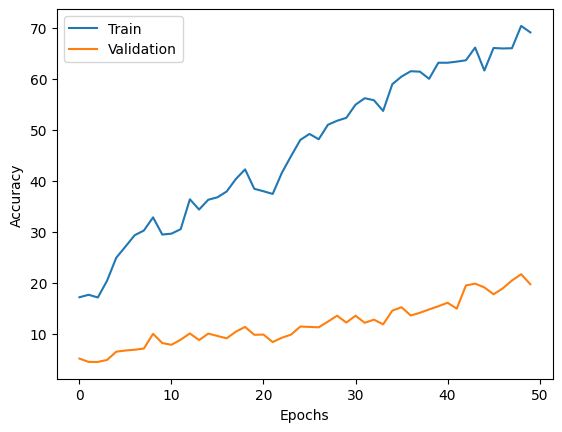

In [36]:
# Plot training and validation accuracy over epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="Validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

###LTSM Right

In [37]:
# Hyperparameters
input_size = 6
hidden_size = 256  # Number of hidden units in RNN
num_classes = 13  # For 0-12 activity classification
epochs = 50
learning_rate = 0.001
batch_size = 512
landa = 0.001  # Regularization term (lambda)

# Prepare the data
X_train_tensor = t.Tensor(X_train_right).type(t.float32)
Y_train_tensor = t.Tensor(y_train_bal).type(t.long)

X_test_tensor = t.Tensor(X_test_right).type(t.float32)
Y_test_tensor = t.Tensor(y_test).type(t.long)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# RNN layers and additional fully connected layer
rnn_layer1 = nn.LSTM(input_size, hidden_size, batch_first=True)
dropout1 = nn.Dropout(0.5)  # Add dropout between RNN layers
rnn_layer2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
dropout2 = nn.Dropout(0.5)  # Add dropout between RNN layers
fc_layer1 = nn.Linear(hidden_size, hidden_size)  # Additional fully connected layer
fc_layer2 = nn.Linear(hidden_size, num_classes)  # Final output layer

# Dropout layer
dropout_fc = nn.Dropout(0.2)  # Add dropout between fully connected layers

# Activation function
relu = nn.ReLU()

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(list(rnn_layer1.parameters()) + list(rnn_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters()), lr=learning_rate)

# Lists to store accuracies and losses
train_accuracy_list = []
validation_accuracy_list = []
train_loss_list = []

# Training loop
for epoch in range(epochs):
    if epoch % 10 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []
    for X, Y in train_data_loader:
        # Forward pass through layers
        out, _ = rnn_layer1(X)
        out = dropout1(out)  # Apply dropout between RNN layers
        out, _ = rnn_layer2(out)
        out = dropout2(out)  # Apply dropout between RNN layers
        out = out[:, -1, :]  # Get the last output of the sequence
        out = relu(fc_layer1(out))  # Apply activation function after first fully connected layer
        out = dropout_fc(out)  # Apply dropout between fully connected layers
        out = fc_layer2(out)

        # Regularization
        l2_term = sum([(w ** 2).sum() for w in list(rnn_layer1.parameters()) + list(rnn_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters())])
        loss = loss_fn(out, Y) + landa * l2_term


        per_epoch_loss_list.append(loss.item())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  # Evaluation on training and validation data
    rnn_layer1.eval()
    rnn_layer2.eval()
    fc_layer1.eval()
    fc_layer2.eval()

    with t.no_grad():
        # Training data
        train_correct, train_total = 0, 0
        for X, Y in train_data_loader:
            out, _ = rnn_layer1(X)
            out = dropout1(out)  # Apply dropout between RNN layers
            out, _ = rnn_layer2(out)
            out = dropout2(out)  # Apply dropout between RNN layers
            out = out[:, -1, :]
            out = relu(fc_layer1(out))
            out = dropout_fc(out)  # Apply dropout between fully connected layers
            out = fc_layer2(out)
            _, predicted = t.max(out.data, 1)
            train_total += Y.size(0)
            train_correct += (predicted == Y).sum().item()
        train_accuracy = 100 * train_correct / train_total

        # Validation data
        validation_correct, validation_total = 0, 0
        for X, Y in test_data_loader:
            out, _ = rnn_layer1(X)
            out = dropout1(out)  # Apply dropout between RNN layers
            out, _ = rnn_layer2(out)
            out = dropout2(out)  # Apply dropout between RNN layers
            out = out[:, -1, :]
            out = relu(fc_layer1(out))
            out = dropout_fc(out)  # Apply dropout between fully connected layers
            out = fc_layer2(out)
            _, predicted = t.max(out.data, 1)
            validation_total += Y.size(0)
            validation_correct += (predicted == Y).sum().item()
        validation_accuracy = 100 * validation_correct / validation_total

        # Print accuracy for the current epoch
        print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}%, Validation Accuracy: {validation_accuracy}%')

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

    # Calculate and append the average loss for the epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

    # Set the model back to train mode
    rnn_layer1.train()
    rnn_layer2.train()
    fc_layer1.train()
    fc_layer2.train()

Epoch 0/50 ---> Train Accuracy: 17.096633143856582%, Validation Accuracy: 5.202312138728324%
Epoch 1/50 ---> Train Accuracy: 18.670747704416264%, Validation Accuracy: 5.81888246628131%
Epoch 2/50 ---> Train Accuracy: 18.05859204197639%, Validation Accuracy: 4.932562620423892%
Epoch 3/50 ---> Train Accuracy: 24.355050284215128%, Validation Accuracy: 5.857418111753372%
Epoch 4/50 ---> Train Accuracy: 27.678181023174464%, Validation Accuracy: 6.666666666666667%
Epoch 5/50 ---> Train Accuracy: 33.53738522081329%, Validation Accuracy: 6.666666666666667%
Epoch 6/50 ---> Train Accuracy: 34.54306952339309%, Validation Accuracy: 8.053949903660886%
Epoch 7/50 ---> Train Accuracy: 35.067774376912986%, Validation Accuracy: 7.976878612716763%
Epoch 8/50 ---> Train Accuracy: 34.105815478793176%, Validation Accuracy: 10.443159922928709%
Epoch 9/50 ---> Train Accuracy: 38.915609969392214%, Validation Accuracy: 8.246628131021195%
Epoch 10/50 ---> Train Accuracy: 36.729339746392654%, Validation Accuracy

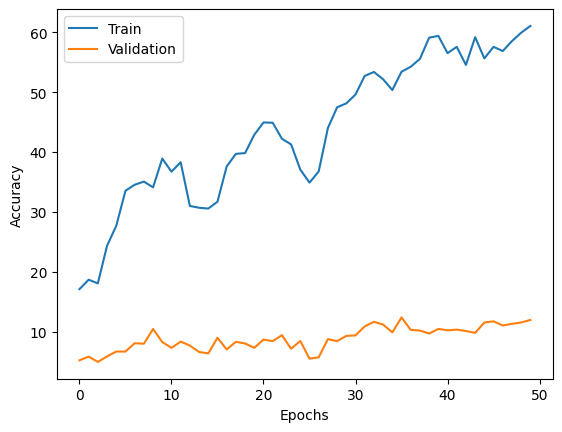

In [38]:
# Plot training and validation accuracy over epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="Validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()